# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import cv2
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

Using TensorFlow backend.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
train_path = 'Project_data/train'
val_path =  'Project_data/val'

In [4]:
print('Training dataset size :', len(train_doc))
print('Validation dataset size :', len(val_doc))

Training dataset size : 663
Validation dataset size : 100


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
class DataGeneratorClass():    
        
    def set_imagebatch_size(self, height=100, width=100, batch_size=20, frames_to_sample=30):
        self.image_height=height
        self.image_width=width
        self.channels=3       # RGB image
        self.num_classes=5    # 5 different Gestures in dataset
        self.total_frames=30  # 30 frames are available in one video
        self.frames_to_sample=frames_to_sample # select the no of frames in the video for model development
        self.batch_size= batch_size  # needs to be selected based on the memory requirment
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int) # select equispaced frames from 30 frames
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.fetch_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            rem_batch_size=len(t)%batch_size  # remaining data points which are left after full batches
        
            if (rem_batch_size != 0):
                batch_data, batch_labels= self.fetch_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,rem_batch_size)
                yield batch_data, batch_labels 
    
    
    def fetch_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,rem_batch_size=0):
    
        curr_batch_size = rem_batch_size if rem_batch_size else batch_size  # curr_batch_size contains current batch size
    
        batch_data = np.zeros((curr_batch_size,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((curr_batch_size,self.num_classes))  # batch_labels is the one hot representation of the output
    
        if (augment): batch_data_aug = np.zeros((curr_batch_size,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(curr_batch_size): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx):  ## select on the required image index
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0) 
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                    
            
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1         
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug]) # add the augmented data to the original batch
            batch_labels=np.concatenate([batch_labels,batch_labels]) # add the labels for augmented data
        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, train_doc, val_doc, train_path, val_path, num_epochs=10):

        self.num_epochs = num_epochs
        train_generator = self.generator(train_path, train_doc, augment=True) # Only training data is Augmented
        val_generator = self.generator(val_path, val_doc, augment=False)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (len(train_doc)%self.batch_size) == 0:
            steps_per_epoch = int(len(train_doc)/self.batch_size)
        else:
            steps_per_epoch = (len(train_doc)//self.batch_size) + 1

        if (len(val_doc)%self.batch_size) == 0:
            validation_steps = int(len(val_doc)/self.batch_size)
        else:
            validation_steps = (len(val_doc)//self.batch_size) + 1
    
        self.history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
    
        
    def plot_history(self):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
        axes[0].plot(self.history.history['categorical_accuracy'])   
        axes[0].plot(self.history.history['val_categorical_accuracy'])
        axes[0].legend(['categorical_accuracy','val_categorical_accuracy'])
        axes[1].plot(self.history.history['loss'])   
        axes[1].plot(self.history.history['val_loss'])
        axes[1].legend(['loss','val_loss'])



## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [6]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here

## 3D CNN Architecture

In [7]:
class Cov3DModelClass(DataGeneratorClass):
    
    def define_model(self,NoOf3Dfilters , filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(NoOf3Dfilters[0], filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        for layer in range(len(NoOf3Dfilters)-1):
            model.add(Conv3D(NoOf3Dfilters[layer+1], filtersize, padding='same'))
            model.add(Activation('relu'))
            model.add(BatchNormalization())
            model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        return model

### Ablation run

The model is run for small no of epocs to check whether the model is complex enough to learn the data. Also this step is used fto find an optimum batch size

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 15, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 7, 60, 60, 32)     13856     
_________________________________________________________________
activation_2 (Activation)    (None, 7, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 60, 60, 32)     128       
__________

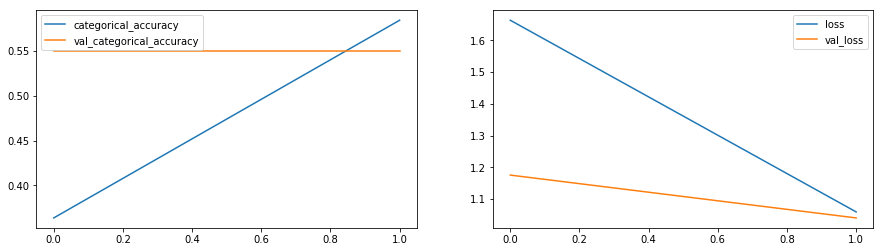

In [8]:
Cov3DInstAbl = Cov3DModelClass()
Cov3DInstAbl.set_imagebatch_size(height=120, width=120, frames_to_sample=15,batch_size=50)
conv3d_ablmodel =Cov3DInstAbl.define_model(NoOf3Dfilters = [16,32], dense_neurons=64,dropout= 0.25)
conv3d_ablmodel.summary()
Cov3DInstAbl.train_model(conv3d_ablmodel, train_doc, val_doc, train_path, val_path, num_epochs=2)
Cov3DInstAbl.plot_history()

=> Facing follwing error when batch size is incresed more than 50. Batch size is set as 50

ResourceExhaustedError: OOM when allocating tensor with shape[120,16,15,120,120] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc

=> Training performance increase with epocs and model is able to learn

### Model 1 : Increase No of epocs

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
activation_5 (Activation)    (None, 15, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 15, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 7, 60, 60, 32)     13856     
_________________________________________________________________
activation_6 (Activation)    (None, 7, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 7, 60, 60, 32)     128       
__________

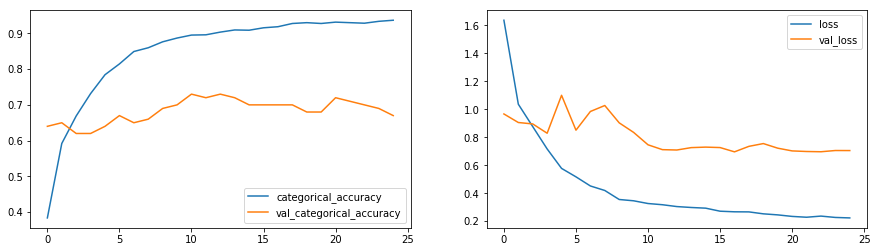

In [10]:
Cov3DInst1 = Cov3DModelClass()
Cov3DInst1.set_imagebatch_size(height=120, width=120, frames_to_sample=15,batch_size=50)
conv3d_model1=Cov3DInst1.define_model(NoOf3Dfilters = [16,32], dense_neurons=64,dropout= 0.25)
conv3d_model1.summary()
Cov3DInst1.train_model(conv3d_model1, train_doc, val_doc, train_path, val_path, num_epochs=25)
Cov3DInst1.plot_history()

### Model 2: 3 layers of 3D convolution

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_7 (Conv3D)            (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
activation_7 (Activation)    (None, 15, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 15, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 7, 60, 60, 32)     13856     
_________________________________________________________________
activation_8 (Activation)    (None, 7, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 7, 60, 60, 32)     128       
__________

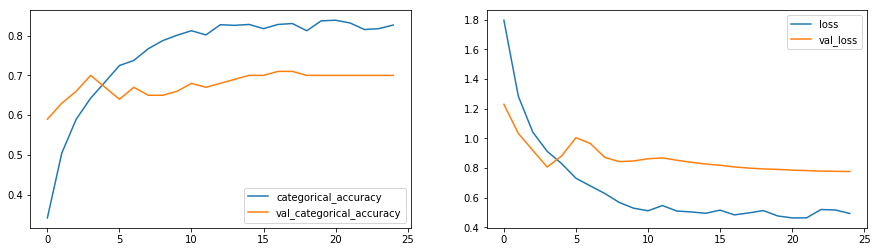

In [12]:
Cov3DInst2 = Cov3DModelClass()
Cov3DInst2.set_imagebatch_size(height=120, width=120, frames_to_sample=15,batch_size=50)
conv3d_model2=Cov3DInst2.define_model(NoOf3Dfilters = [16,32, 64], dense_neurons=64,dropout= 0.25)
conv3d_model2.summary()
Cov3DInst2.train_model(conv3d_model2, train_doc, val_doc, train_path, val_path, num_epochs=25)
Cov3DInst2.plot_history()

### Model 3: 4 layers of 3D convolution

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_17 (Conv3D)           (None, 16, 120, 120, 8)   656       
_________________________________________________________________
activation_17 (Activation)   (None, 16, 120, 120, 8)   0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 16, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_17 (MaxPooling (None, 8, 60, 60, 8)      0         
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 8, 60, 60, 16)     3472      
_________________________________________________________________
activation_18 (Activation)   (None, 8, 60, 60, 16)     0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 8, 60, 60, 16)     64        
__________

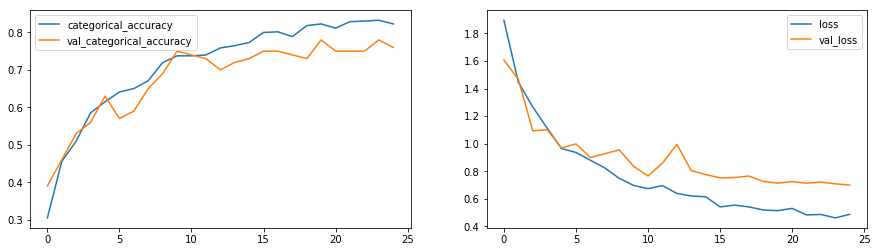

In [14]:
Cov3DInst3 = Cov3DModelClass()
Cov3DInst3.set_imagebatch_size(height=120, width=120, frames_to_sample=16,batch_size=20)
conv3d_model3=Cov3DInst3.define_model(NoOf3Dfilters = [8, 16,32,64 ], dense_neurons=64, dropout= 0.25)
conv3d_model3.summary()
Cov3DInst3.train_model(conv3d_model3, train_doc, val_doc, train_path, val_path, num_epochs=25)
Cov3DInst3.plot_history()

### Model 3: 4 layers of 3D convolution with increased image size

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 30, 160, 160, 8)   656       
_________________________________________________________________
activation_13 (Activation)   (None, 30, 160, 160, 8)   0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 30, 160, 160, 8)   32        
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 15, 80, 80, 8)     0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 15, 80, 80, 16)    3472      
_________________________________________________________________
activation_14 (Activation)   (None, 15, 80, 80, 16)    0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 15, 80, 80, 16)    64        
__________

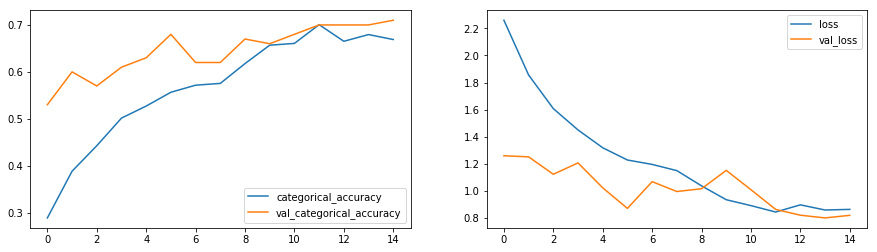

In [11]:
Cov3DInst4 = Cov3DModelClass()
Cov3DInst4.set_imagebatch_size(height=160, width=160, frames_to_sample=30,batch_size=20)
conv3d_model4 = Cov3DInst4.define_model(NoOf3Dfilters = [8, 16,32,64], dense_neurons=128,dropout=0.5)
conv3d_model4.summary()
Cov3DInst4.train_model(conv3d_model4, train_doc, val_doc, train_path, val_path, num_epochs=15)
Cov3DInst4.plot_history()

In [13]:
Cov3DInst4.train_model(conv3d_model4, train_doc, val_doc, train_path, val_path, num_epochs=10)

Epoch 1/10
34/34 [==============================] - 195s 6s/step - loss: 0.8307 - categorical_accuracy: 0.6965 - val_loss: 0.7954 - val_categorical_accuracy: 0.7200

Epoch 00001: saving model to model_init_2020-09-1416_16_22.898189/model-00001-0.81903-0.70136-0.79535-0.72000.h5
Epoch 2/10
34/34 [==============================] - 187s 5s/step - loss: 0.8257 - categorical_accuracy: 0.7013 - val_loss: 0.7990 - val_categorical_accuracy: 0.7100

Epoch 00002: saving model to model_init_2020-09-1416_16_22.898189/model-00002-0.81756-0.70211-0.79904-0.71000.h5
Epoch 3/10
34/34 [==============================] - 185s 5s/step - loss: 0.8267 - categorical_accuracy: 0.7042 - val_loss: 0.7958 - val_categorical_accuracy: 0.7200

Epoch 00003: saving model to model_init_2020-09-1416_16_22.898189/model-00003-0.81996-0.70513-0.79582-0.72000.h5
Epoch 4/10
34/34 [==============================] - 185s 5s/step - loss: 0.8145 - categorical_accuracy: 0.6957 - val_loss: 0.7654 - val_categorical_accuracy: 0.730

## CNN - RNN architecture

In [8]:
class RNNCNNModelClass(DataGeneratorClass):
    
    def define_model(self,NoOf2Dfilters, gru_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(NoOf2Dfilters[0], (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(NoOf2Dfilters[1], (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(NoOf2Dfilters[2], (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(NoOf2Dfilters[3], (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 20, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 20, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 20, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 20, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 20, 30, 30, 64)    18496     
__________

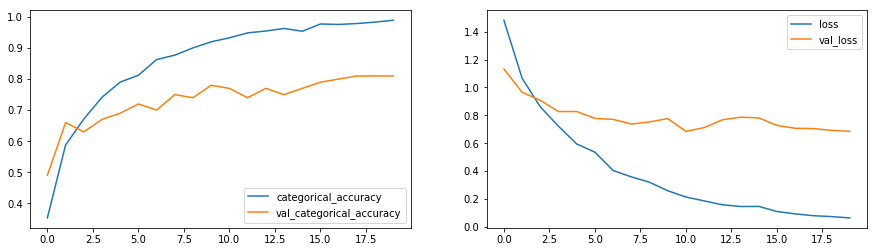

In [9]:
RNNCNNInst1 = RNNCNNModelClass()
RNNCNNInst1.set_imagebatch_size(height=120, width=120, frames_to_sample=20,batch_size=20)
cnnrnn_model1=RNNCNNInst1.define_model(NoOf2Dfilters = [16,32,64, 128], gru_cells=128, dense_neurons=128,dropout=0.25)
cnnrnn_model1.summary()
RNNCNNInst1.train_model(cnnrnn_model1, train_doc, val_doc, train_path, val_path, num_epochs=20)
RNNCNNInst1.plot_history()

## CNN-RNN Architecture with Transfer learning

These models uses MobilNet architecture with pretrained weights from ImageNet dataset for the 2D convolution part

In [15]:
from keras.applications import mobilenet

In [16]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNNModelWithTLClass(DataGeneratorClass):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25, flgTrainable=True):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        if(flgTrainable==False):
          for layer in model.layers:
            layer.trainable = False

        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

17227776/17225924 [==============================] - 2s 0us/step


### Model with trainable weights for MobileNet

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_14 (TimeDis (None, 20, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_15 (TimeDis (None, 20, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_16 (TimeDis (None, 20, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_17 (TimeDis (None, 20, 1024)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               442752    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
__________

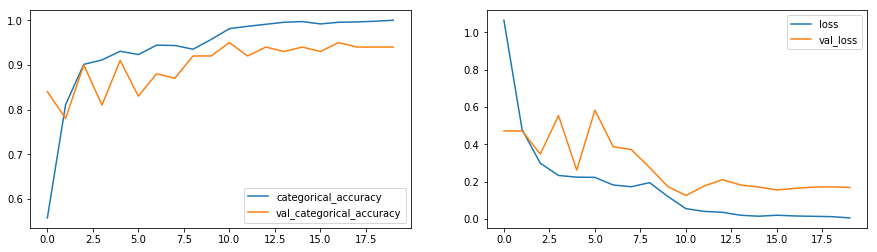

In [12]:
RNNCNNInst2 = RNNCNNModelWithTLClass()
RNNCNNInst2.set_imagebatch_size(height=120, width=120, frames_to_sample=20,batch_size=10)
cnnrnn_model2=RNNCNNInst2.define_model( gru_cells=128, dense_neurons=128,dropout=0.25, flgTrainable=True)
cnnrnn_model2.summary()
RNNCNNInst2.train_model(cnnrnn_model2, train_doc, val_doc, train_path, val_path, num_epochs=20)
RNNCNNInst2.plot_history()

### Model with not trainable weights for MobileNet

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_22 (TimeDis (None, 20, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_23 (TimeDis (None, 20, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_24 (TimeDis (None, 20, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_25 (TimeDis (None, 20, 1024)          0         
_________________________________________________________________
gru_4 (GRU)                  (None, 128)               442752    
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
__________

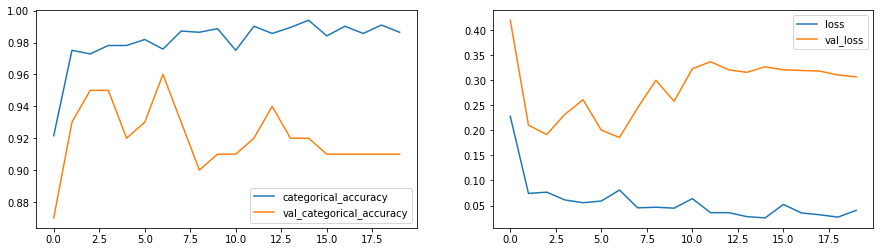

In [14]:
RNNCNNInst3 = RNNCNNModelWithTLClass()
RNNCNNInst3.set_imagebatch_size(height=120, width=120, frames_to_sample=20,batch_size=5)
cnnrnn_model3= RNNCNNInst3.define_model( gru_cells=128, dense_neurons=128,dropout=0.25, flgTrainable=False)
cnnrnn_model3.summary()
RNNCNNInst3.train_model(cnnrnn_model3, train_doc, val_doc, train_path, val_path, num_epochs=20)
RNNCNNInst3.plot_history()